### Variational Autoencoder. 

In [87]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torchvision as tv

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Load MNIST dataset.

In [88]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])
#transform = tv.transforms.Compose([tv.transforms.ToTensor(),
#                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

datasets = {
    'train': tv.datasets.MNIST(os.path.join('mnist', 'train'), 
                               train=True, 
                               download=True, 
                               transform=transform),
    'test': tv.datasets.MNIST(os.path.join('mnist', 'test'), 
                              train=False, 
                              download=True, 
                              transform=transform),    
}

dataloaders = {
    name: torch.utils.data.DataLoader(value, batch_size=100, shuffle=True) for name, value in datasets.items()
}    


In [89]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, .5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

torch.Size([100, 1, 28, 28])

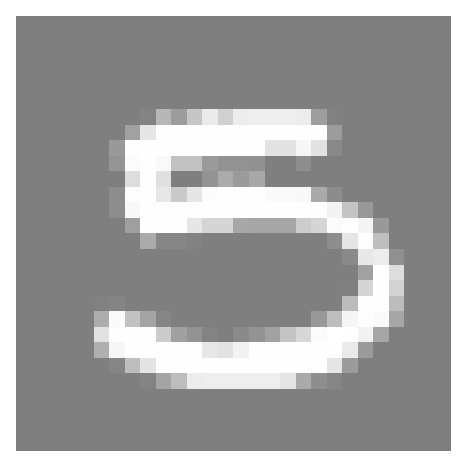

In [90]:
image, label = next(iter(dataloaders['train']))
imshow(image[0])
image.shape

#### Define model for training Variational Auto Encoder.

In [91]:
class Model(torch.nn.Module):
    def __init__(self, input_size, code_size, hidden_size):
        super(Model, self).__init__()
        self.code_size = code_size
        self.input_size = input_size
        self.encoder_fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc_mu = torch.nn.Linear(hidden_size, code_size)
        self.fc_logvar = torch.nn.Linear(hidden_size, code_size)
        
        self.decoder_fc1 = torch.nn.Linear(code_size, hidden_size)
        self.decoder_fc2 = torch.nn.Linear(hidden_size, input_size)


    def encode(self, x):
        h = F.relu(self.encoder_fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(h))

    def reparam(self, mu, logvar):
        if self.training:
            sigma = torch.exp(0.5*logvar)
            e = torch.randn_like(sigma)
            return e.mul(sigma).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar


In [92]:
# Loss function
def vae_loss(x_hat, x, mu, log_variance):
    """ Return value of lower bound of log likelihood.
    """
    batch_size, x_size = x_hat.shape
    bce = F.binary_cross_entropy(x_hat, x.view(-1, 784))
##    mse = torch.nn.MSELoss(size_average=True)(x_hat, x.view(-1, x_size))

    divergence = -0.5 * torch.sum(1. + log_variance - mu.pow(2) - log_variance.exp())
    divergence /= (batch_size * x_size)
    print("BCE={} DL={}".format(bce, divergence))
    return bce + divergence
    

In [93]:
N = 28*28
model = Model(N, 20, 500)

lr = 0.001
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
for x, y in iter(dataloaders['train']):
    model.train()
#    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    x_hat, mu, logvar = model(x)
    loss = vae_loss(x_hat, x, mu, logvar)
    
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    print("Loss={}".format(loss.item()))
##    print ("y_hat: {}".format(y_hat.shape))
##    im= y_hat.detach().numpy()
##    im.resize(x.shape[0], 1, 28, 28)
##    imshow(torch.Tensor(im[0]))
##    break


BCE=0.6992330551147461 DL=0.00012644010712392628
Loss=0.6993594765663147
BCE=0.658051073551178 DL=0.00034005509223788977
Loss=0.6583911180496216
BCE=0.616249144077301 DL=0.0007598517113365233
Loss=0.6170089840888977
BCE=0.5790895223617554 DL=0.0015414381632581353
Loss=0.5806309580802917
BCE=0.530261754989624 DL=0.0026548714376986027
Loss=0.5329166054725647
BCE=0.4884532392024994 DL=0.005259022116661072
Loss=0.49371224641799927
BCE=0.43184414505958557 DL=0.008879531174898148
Loss=0.4407236874103546
BCE=0.384057879447937 DL=0.017581399530172348
Loss=0.40163928270339966
BCE=0.35823777318000793 DL=0.029921989887952805
Loss=0.38815975189208984
BCE=0.3489466607570648 DL=0.04347279667854309
Loss=0.3924194574356079
BCE=0.32345399260520935 DL=0.03765493631362915
Loss=0.3611089289188385
BCE=0.31920576095581055 DL=0.0360402911901474
Loss=0.35524606704711914
BCE=0.3031214773654938 DL=0.026516253128647804
Loss=0.329637736082077
BCE=0.29702475666999817 DL=0.020304974168539047
Loss=0.3173297345638275

BCE=0.20129336416721344 DL=0.01700643077492714
Loss=0.21829979121685028
BCE=0.2012627124786377 DL=0.01679556630551815
Loss=0.2180582731962204
BCE=0.206822469830513 DL=0.016772735863924026
Loss=0.22359520196914673
BCE=0.20181050896644592 DL=0.01640917733311653
Loss=0.21821968257427216
BCE=0.1984919160604477 DL=0.01687348075211048
Loss=0.21536539494991302
BCE=0.19668307900428772 DL=0.017159441486001015
Loss=0.21384252607822418
BCE=0.2025136649608612 DL=0.017051583155989647
Loss=0.2195652425289154
BCE=0.19913305342197418 DL=0.01633666642010212
Loss=0.21546971797943115
BCE=0.18868763744831085 DL=0.017394449561834335
Loss=0.20608209073543549
BCE=0.19427159428596497 DL=0.018730109557509422
Loss=0.21300169825553894
BCE=0.20166487991809845 DL=0.017893340438604355
Loss=0.2195582240819931
BCE=0.2052769660949707 DL=0.01641818694770336
Loss=0.2216951549053192
BCE=0.1947181075811386 DL=0.018557488918304443
Loss=0.21327559649944305
BCE=0.19630885124206543 DL=0.01715393364429474
Loss=0.21346278488636

Loss=0.1815974861383438
BCE=0.16774582862854004 DL=0.021463677287101746
Loss=0.18920950591564178
BCE=0.16118378937244415 DL=0.02311134710907936
Loss=0.18429513275623322
BCE=0.16554462909698486 DL=0.022515662014484406
Loss=0.18806028366088867
BCE=0.16250862181186676 DL=0.02082088217139244
Loss=0.1833295077085495
BCE=0.16808710992336273 DL=0.021181413903832436
Loss=0.18926852941513062
BCE=0.15975956618785858 DL=0.02246490679681301
Loss=0.18222446739673615
BCE=0.1645001322031021 DL=0.020697811618447304
Loss=0.18519794940948486
BCE=0.1652483195066452 DL=0.020379776135087013
Loss=0.18562810122966766
BCE=0.1674620509147644 DL=0.02010551281273365
Loss=0.1875675618648529
BCE=0.16669631004333496 DL=0.020820727571845055
Loss=0.18751703202724457
BCE=0.1620834469795227 DL=0.021581394597887993
Loss=0.18366484344005585
BCE=0.16752363741397858 DL=0.020589575171470642
Loss=0.18811321258544922
BCE=0.16745911538600922 DL=0.02016635425388813
Loss=0.1876254677772522
BCE=0.16807305812835693 DL=0.0221537426

BCE=0.14847932755947113 DL=0.023716606199741364
Loss=0.1721959412097931
BCE=0.1514662802219391 DL=0.023048268631100655
Loss=0.1745145469903946
BCE=0.14324603974819183 DL=0.023375408723950386
Loss=0.16662144660949707
BCE=0.1475345343351364 DL=0.02417561411857605
Loss=0.17171014845371246
BCE=0.1461009830236435 DL=0.02287767454981804
Loss=0.16897866129875183
BCE=0.14679008722305298 DL=0.022559044882655144
Loss=0.16934913396835327
BCE=0.15262088179588318 DL=0.02444177307188511
Loss=0.17706266045570374
BCE=0.14812742173671722 DL=0.023760275915265083
Loss=0.17188769578933716
BCE=0.14839746057987213 DL=0.02470102347433567
Loss=0.17309848964214325
BCE=0.15014947950839996 DL=0.02339472621679306
Loss=0.17354419827461243
BCE=0.1421567052602768 DL=0.02545287273824215
Loss=0.1676095724105835
BCE=0.14241378009319305 DL=0.025918351486325264
Loss=0.16833212971687317
BCE=0.14085006713867188 DL=0.024492405354976654
Loss=0.16534247994422913
BCE=0.1534152328968048 DL=0.02495587058365345
Loss=0.17837110161

Loss=0.16239938139915466
BCE=0.1413108855485916 DL=0.026139240711927414
Loss=0.16745012998580933
BCE=0.14356191456317902 DL=0.0258280411362648
Loss=0.16938996315002441
BCE=0.13775964081287384 DL=0.025352217257022858
Loss=0.1631118655204773
BCE=0.13282066583633423 DL=0.025357136502861977
Loss=0.15817780792713165
BCE=0.1327579915523529 DL=0.02469486929476261
Loss=0.15745286643505096
BCE=0.13943345844745636 DL=0.026063639670610428
Loss=0.1654970943927765
BCE=0.13342873752117157 DL=0.025688398629426956
Loss=0.15911713242530823
BCE=0.13547535240650177 DL=0.025790460407733917
Loss=0.16126582026481628
BCE=0.1344137191772461 DL=0.026934269815683365
Loss=0.16134798526763916
BCE=0.1306591033935547 DL=0.025416994467377663
Loss=0.1560761034488678
BCE=0.13280978798866272 DL=0.026843849569559097
Loss=0.15965363383293152
BCE=0.13468283414840698 DL=0.02723510190844536
Loss=0.16191793978214264
BCE=0.13482996821403503 DL=0.025787951424717903
Loss=0.1606179177761078
BCE=0.13279011845588684 DL=0.028226561

BCE=0.1292714923620224 DL=0.027943024411797523
Loss=0.15721452236175537
BCE=0.1282392293214798 DL=0.02703014388680458
Loss=0.15526936948299408
BCE=0.13101090490818024 DL=0.027618177235126495
Loss=0.15862908959388733
BCE=0.12446881085634232 DL=0.02645406685769558
Loss=0.15092287957668304
BCE=0.1306772232055664 DL=0.02687326818704605
Loss=0.15755048394203186
BCE=0.12891654670238495 DL=0.02751500904560089
Loss=0.15643155574798584
BCE=0.12596696615219116 DL=0.026624329388141632
Loss=0.1525912880897522
BCE=0.12627775967121124 DL=0.027364909648895264
Loss=0.1536426693201065
BCE=0.13003623485565186 DL=0.028245052322745323
Loss=0.15828128159046173
BCE=0.13097836077213287 DL=0.03039409965276718
Loss=0.16137245297431946
BCE=0.1353897750377655 DL=0.029499143362045288
Loss=0.1648889183998108
BCE=0.13206759095191956 DL=0.029893547296524048
Loss=0.1619611382484436
BCE=0.12665143609046936 DL=0.02930198796093464
Loss=0.15595342218875885
BCE=0.12547414004802704 DL=0.028475988656282425
Loss=0.1539501249

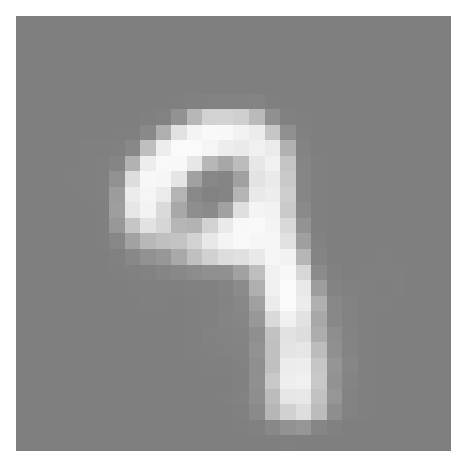

In [103]:
model.eval()
with torch.no_grad():
    for x, y in iter(dataloaders['train']):
        x_hat, _, _ = model.forward(x)
        im = x_hat.detach().numpy()
        im.resize(x_hat.shape[0], 1, 28, 28)
        imshow(torch.Tensor(im[0]))
                  
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
        n = min(x.size(0), 8)
        comparison = torch.cat([x[:n],
                                  x_hat.view(x.shape[0], 1, 28, 28)[:n]])
        tv.utils.save_image(comparison.data.cpu(),
                     'reconstruction_' + str(1) + '.png', nrow=n)

        break